In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt

## Define list of the options to choose from and get from the function full URL string

In [38]:
## Symbols of the Investment Funds (with their Polish description)
number_to_symbol = {
    '1': '2711.n', # 'surowce'
    '2': '3187.n', # 'akcje_NN'
    '3': '1472.n', # 'akcje_Uniqa'
    '4': '4604.n', # 'makroalokacje_Uniqa'
    '5': '2735.n'  # 'zrownowazone_NN'
}

def URL_to_webscrapping(num):
    ## Make a url which including symbol from dictionary above 
    ## and date range for later webscraping Investment Fund prices
    symbol = number_to_symbol[str(num)]
    ## Both dates were taken as the examples only
    start_date = 20170101
    end_date = f"20{dt.date.today().strftime('%y%m%d')}"
    return f'https://stooq.com/q/d/l/?s={symbol}&d1={start_date}&d2={end_date}&i=d'

url_name = URL_to_webscrapping(4)
print(f'URL to web-scraping: {url_name} \n')

URL to web-scraping: https://stooq.com/q/d/l/?s=4604.n&d1=20170101&d2=20220830&i=d 



In [39]:
pd.read_csv(url_name).head()

,Date,Open,High,Low,Close
0,2017-01-02,103.25,103.25,103.25,103.25
1,2017-01-03,103.08,103.08,103.08,103.08
2,2017-01-04,103.24,103.24,103.24,103.24
3,2017-01-05,103.03,103.03,103.03,103.03
4,2017-01-09,102.66,102.66,102.66,102.66


In [40]:
pd.read_csv(url_name).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1390 entries, 0 to 1389
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1390 non-null   object 
 1   Open    1390 non-null   float64
 2   High    1390 non-null   float64
 3   Low     1390 non-null   float64
 4   Close   1390 non-null   float64
dtypes: float64(4), object(1)
memory usage: 54.4+ KB


### Are all columns with prices have the same values?

In [41]:
def price_cols_compare():
    _ = pd.read_csv(url_name)
    if ((_['Close']-_['Open']).sum() == 0.0):
        _ = _.drop(['Open'], axis=1)
    if ((_['High']-_['Low']).sum() == 0.0):
        _ = _.drop(['High', 'Low'], axis=1)
    return _

df = price_cols_compare()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1390 entries, 0 to 1389
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1390 non-null   object 
 1   Close   1390 non-null   float64
dtypes: float64(1), object(1)
memory usage: 21.8+ KB


### We will also change name of the 'Close' columns to 'Price'

In [42]:
df = df.rename(columns={'Close': 'Price'})

In [43]:
# convert to datetime64
df['Date'] = df['Date'].apply(pd.Timestamp)

## Set date as an index (it will not be take as a column into prediction)
df.set_index('Date', inplace=True)
df.head()

,Price
Date,
2017-01-02,103.25
2017-01-03,103.08
2017-01-04,103.24
2017-01-05,103.03
2017-01-09,102.66


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1390 entries, 2017-01-02 to 2022-08-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1390 non-null   float64
dtypes: float64(1)
memory usage: 21.7 KB


### We have not enough data (columns) to make good predictions, so from column 'Price' will be calculated additionaly parameters: 
- 'Daily returns' (as a percent price change)
- 'MA30' (30 days moving average)
- 'STD30' (30 days standard deviation)
- 'Upper Band', 'Lower Band' (respectively: the highest and lowest values at exactly day)

In [45]:
df['Daily_returns'] = 100*(df['Price'].pct_change())
df['MA30'] = df['Price'].rolling(window = 30).mean()
df['STD30'] = df['Price'].rolling(window = 30).std()
df['Upper Band'] = df['MA30'] + (df['STD30'] * 2)
df['Lower Band'] = df['MA30'] - (df['STD30'] * 2)

df.head()

,Price,Daily_returns,MA30,STD30,Upper Band,Lower Band
Date,,,,,,
2017-01-02,103.25,NaN,NaN,NaN,NaN,NaN
2017-01-03,103.08,-0.164649,NaN,NaN,NaN,NaN
2017-01-04,103.24,0.155219,NaN,NaN,NaN,NaN
2017-01-05,103.03,-0.203410,NaN,NaN,NaN,NaN
2017-01-09,102.66,-0.359119,NaN,NaN,NaN,NaN


#### Plot with different prices over time

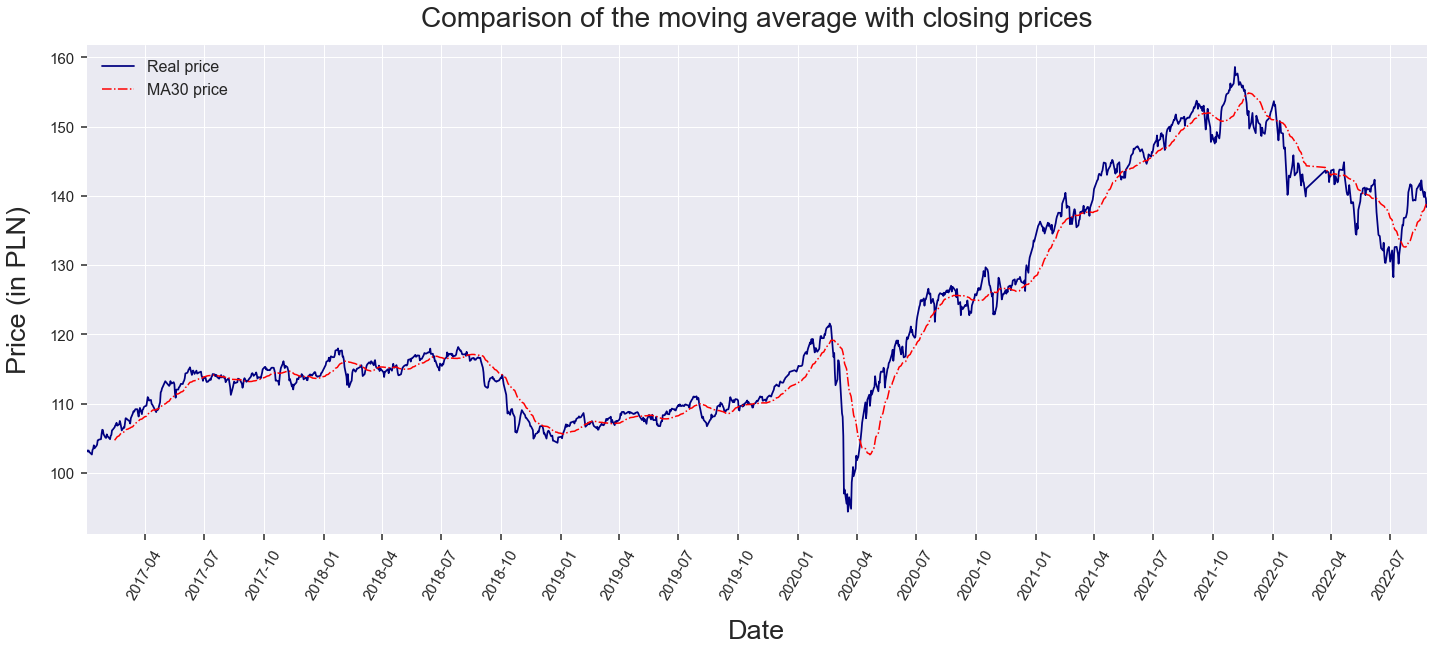

In [46]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(24, 9))

x = df.index

plt.plot(x, df['Price'], color='navy', label='Real price')
plt.plot(x, df['MA30'], color='red', lw=1.5, ls='-.', label='MA30 price')
plt.xlim([x.min(), x.max()])
plt.xlabel('Date', fontdict={'fontsize':27}, labelpad=18)
plt.ylabel('Price (in PLN)', fontdict={'fontsize':27}, labelpad=18)
plt.tick_params(axis='both', width=1.5, length=6, labelsize=15)
plt.tick_params(axis='x', labelrotation=60)
plt.title("Comparison of the moving average with closing prices", fontsize=28, pad=18)
plt.legend(loc='upper left', fontsize=16)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))

plt.show()

#### Plot with daily return (in percent)

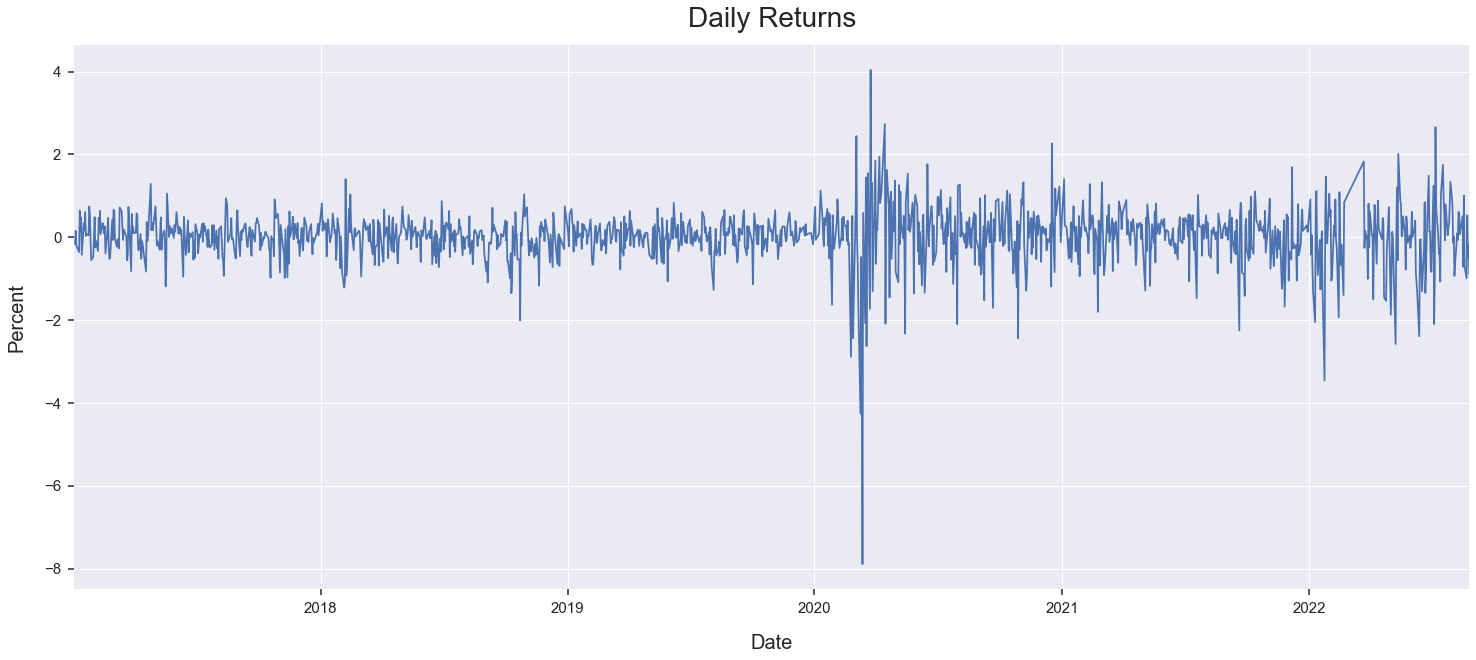

In [47]:
plt.figure(figsize=(25, 10))

plt.plot(x, df['Daily_returns'])
plt.xlim([x.min(), x.max()])
plt.xlabel("Date", fontsize=20, labelpad=18)
plt.ylabel("Percent", fontsize=20, labelpad=18)
plt.tick_params(axis='both', width=1.5, length=6, labelsize=15)
plt.title("Daily Returns", fontsize=28, pad=18)

plt.show()

#### Plot prices, moving average and both prices band

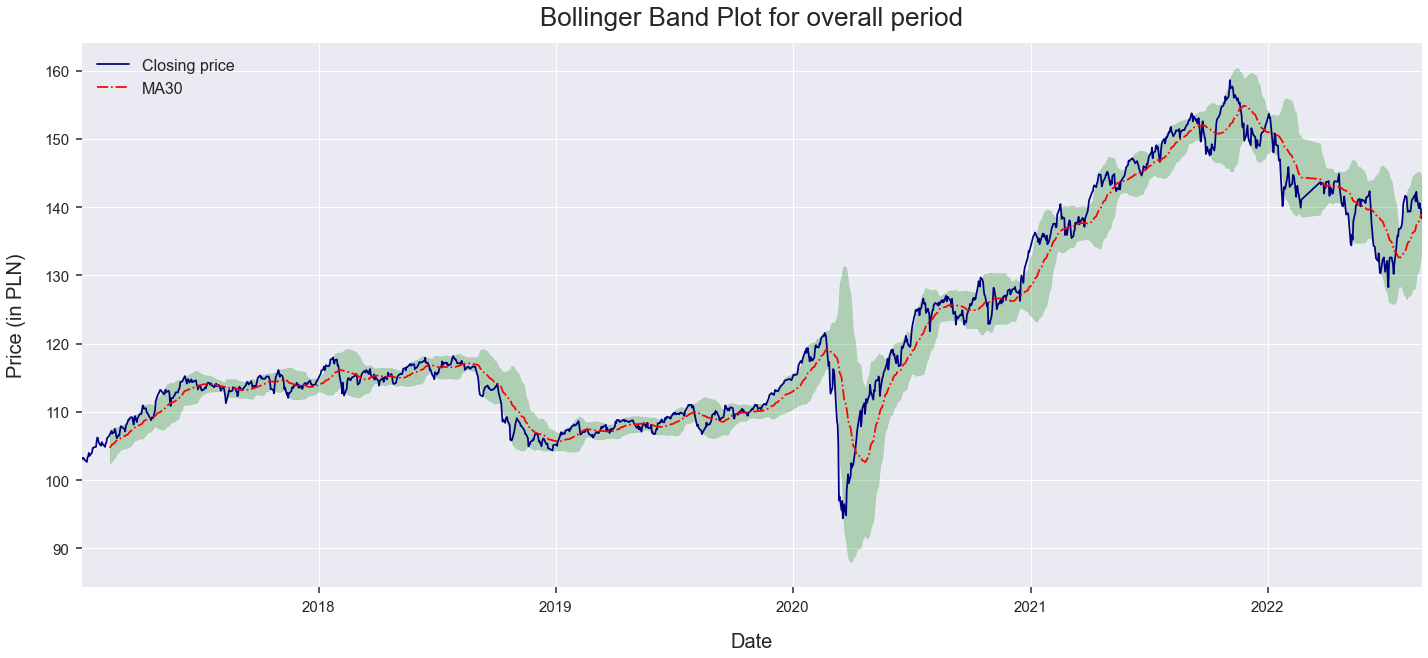

In [48]:
f, ax = plt.subplots(figsize=(24, 10))

columns_list = ['Price', 'MA30']
colors_list = ['navy', 'red']
line_styles = ['-', '-.']
labels_list = ['Closing price', 'MA30']

for column, color, style, label in zip(columns_list, colors_list, line_styles, labels_list):
    plt.plot(x, df[column], color=color, ls=style, label=label)

ax.fill_between(x, df['Upper Band'], df['Lower Band'], color='green', alpha=0.25)
plt.xlabel("Date", fontsize=20, labelpad=18)
plt.ylabel('Price (in PLN)', fontsize=20, labelpad=18)
plt.tick_params(axis='both', width=1.5, length=6, labelsize=15)
plt.xlim([x.min(), x.max()])
plt.title("Bollinger Band Plot for overall period", fontsize=26, pad=18)
plt.legend(loc='upper left', fontsize=16)

plt.show()

## Prices prediction

In [49]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


#### Prepare features and target data for cross-validation

In [50]:
df = df.dropna()
X, y = df.drop(['Price'], axis=1), df['Price']

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [51]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor

In [52]:
def prices_prediction(regr_name, params):
    model = Pipeline(steps=[('std', StandardScaler()),
                            ('regr', regr_name)]) 
    grid = GridSearchCV(model, params, scoring='r2', n_jobs=12, refit=True, cv=tscv)       
    y_pred = np.round(grid.fit(X_train, y_train).predict(X_test), 2)

    RMSE = np.sqrt(mean_squared_error(y_test, y_pred)).round(3)
    train_score = (100 * grid.score(X_train, y_train)).round(2)
    test_score = (100 * grid.score(X_test, y_test)).round(2)
    print(f'For {regr_name.__class__.__name__} results are:')
    print(f"\tRMSE={RMSE}, Train score={train_score}%, Test Score={test_score}%")
    
    return y_pred, test_score

In [53]:
regressors_name = ['LinearRegr', 'Lasso', 'Ridge', 
                   'DecisionTree', 'RandomTree', 'XGBRegr',
                   'LinearSVR', 'SVR_poly', 'SVR_rbf', 'KNNRegr']

regressors_list = [LinearRegression(), Lasso(max_iter=1e9, warm_start=True, random_state=42), Ridge(max_iter=1e9, random_state=42), 
                   DecisionTreeRegressor(random_state=42), RandomForestRegressor(random_state=42, warm_start=True), XGBRegressor(), 
                   LinearSVR(max_iter=1e9, random_state=42), SVR(max_iter=1e9, cache_size=1000, kernel='poly'), SVR(max_iter=1e9, cache_size=1000, kernel='rbf'), 
                   KNeighborsRegressor()]

In [54]:
linregr_params = {'regr__fit_intercept': [True, False]}

lasso_params = {'regr__alpha': np.logspace(-4, 0, 100),
                'regr__selection': ['cyclic', 'random']}

ridge_params = {'regr__alpha': np.logspace(-4, 0, 100)}

decision_tree_params = {'regr__criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
                        'regr__min_samples_split': [2, 3, 4],
                        'regr__min_samples_leaf': [1, 2, 3]}

rf_params = {'regr__n_estimators': np.arange(10, 310, 10),
             'regr__min_samples_split': [2, 3, 4],
             'regr__min_samples_leaf': [1, 2, 3]}

XGB_params = {'regr__learning_rate': np.logspace(-4, -1, 25),
              'regr__n_estimators': np.arange(10, 210, 10)}

LinearSVR_params = {'regr__C': np.logspace(-5, 1, 50),
                    'regr__epsilon': np.linspace(0.05, 0.95, 19)}

SVR_poly_params = {'regr__C': np.logspace(-1, 2, 12),
                   'regr__degree': [3, 4],
                   'regr__coef0': [-2, -1, 1, 2],
                   'regr__epsilon': np.logspace(-3, -1, 8)}

SVR_rbf_params = {'regr__C': np.logspace(-1, 2, 30),
                  'regr__epsilon': np.logspace(-3, -1, 10)}

KNN_params = {'regr__n_neighbors': np.arange(3, 31, 1),
              'regr__weights': ["uniform", "distance"],
              'regr__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'regr__leaf_size': np.arange(5, 55, 5)}

In [55]:
df_prices = pd.DataFrame(index=y_test.index, columns=regressors_name)
df_prices['y_test'] = y_test

df_scores = pd.DataFrame(index=[0])

### **1) Linear regressors**

In [56]:
for regr_col_name, regressor, hyperparams in zip(regressors_name[0:3], regressors_list[0:3], [linregr_params, lasso_params, ridge_params]):
    results = prices_prediction(regressor, hyperparams)
    df_prices[regr_col_name] = results[0]
    df_scores[regr_col_name] = results[1]

For LinearRegression results are:
	RMSE=3.854, Train score=95.97%, Test Score=71.55%
For Lasso results are:
	RMSE=3.853, Train score=95.97%, Test Score=71.56%
For Ridge results are:
	RMSE=3.849, Train score=95.97%, Test Score=71.61%


### **2) Tree-based regressors**

In [57]:
for regr_col_name, regressor, hyperparams in zip(regressors_name[3:6], regressors_list[3:6], [decision_tree_params, rf_params, XGB_params]):
    results = prices_prediction(regressor, hyperparams)
    df_prices[regr_col_name] = results[0]
    df_scores[regr_col_name] = results[1]

For DecisionTreeRegressor results are:
	RMSE=5.517, Train score=98.66%, Test Score=41.7%
For RandomForestRegressor results are:
	RMSE=4.455, Train score=99.67%, Test Score=61.98%
For XGBRegressor results are:
	RMSE=4.39, Train score=99.79%, Test Score=63.08%


### **3) SVR algorithms**

In [58]:
for regr_col_name, regressor, hyperparams in zip(regressors_name[6:9], regressors_list[6:9], [LinearSVR_params, SVR_poly_params, SVR_rbf_params]):
    results = prices_prediction(regressor, hyperparams)
    df_prices[regr_col_name] = results[0]
    df_scores[regr_col_name] = results[1]

For LinearSVR results are:
	RMSE=4.242, Train score=95.16%, Test Score=65.53%
For SVR results are:
	RMSE=5.917, Train score=97.31%, Test Score=32.92%
For SVR results are:
	RMSE=11.039, Train score=90.83%, Test Score=-133.46%


### **4) Nearest neighbours**

In [59]:
results = prices_prediction(KNeighborsRegressor(), KNN_params)
df_prices['KNNRegr'] = results[0]
df_scores['KNNRegr'] = results[1]

For KNeighborsRegressor results are:
	RMSE=3.872, Train score=98.07%, Test Score=71.27%


### Saving the results of price preditions 

In [60]:
df_prices.to_csv('prices_comparison.csv')
df_scores.to_csv('testing_scores.csv', index_label=False)

In [25]:
df_prices

,LinearRegr,Lasso,Ridge,DecisionTree,RandomTree,XGBRegr,LinearSVR,SVR_poly,SVR_rbf,KNNRegr,y_test
Date,,,,,,,,,,,
2021-08-31,152.76,152.75,152.74,151.85,151.23,151.389999,151.93,151.36,141.84,151.30,152.17
2021-09-01,153.18,153.18,153.17,151.85,151.35,151.410004,152.28,151.54,141.54,151.38,152.53
2021-09-02,153.25,153.25,153.24,151.85,151.50,151.410004,152.36,151.66,141.53,151.38,152.83
2021-09-03,153.00,153.00,152.99,151.85,151.23,151.389999,152.17,151.55,141.22,151.30,152.74
2021-09-06,154.08,154.08,154.07,151.85,151.50,151.550003,153.19,152.57,139.40,150.20,153.75
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,136.22,136.22,136.21,143.55,139.56,139.270004,138.30,139.81,131.20,137.99,140.83
2022-08-18,139.12,139.12,139.12,143.55,140.39,139.990005,140.72,141.84,131.44,138.67,142.25
2022-08-19,137.16,137.16,137.15,143.55,139.79,140.229996,138.97,140.56,132.74,137.99,141.25


### Sort `df_scores` in descending order and get 3 best regressors

In [70]:
df_scores = pd.read_csv('testing_scores.csv')
(df_scores.T.sort_values(axis=0, by=[0], ascending=False)).iloc[:3,:]

,0
Ridge,71.61
Lasso,71.56
LinearRegr,71.55


### Graphical comparison of the real and calculating values

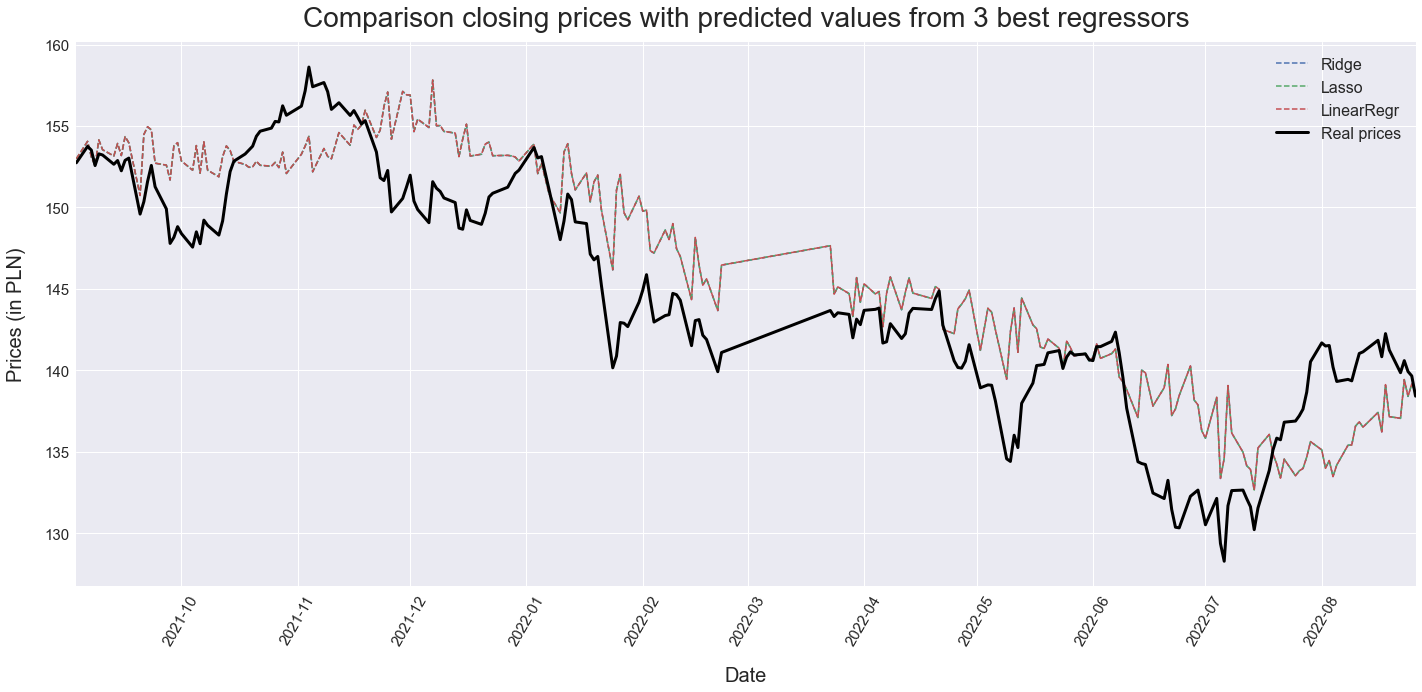

In [72]:
f = plt.figure(figsize=(24, 10))

x = df_prices.index

for i in ['Ridge', 'Lasso', 'LinearRegr']:
    plt.plot(x, df_prices[i], lw=1.5, ls='--', label=f'{i}')
plt.plot(x, df_prices['y_test'], lw=3, color='k', label='Real prices')

plt.xlabel('Date', fontsize=20, labelpad=18)
plt.ylabel('Prices (in PLN)', fontsize=20, labelpad=18)
plt.xticks(fontsize=15, rotation=60)
plt.yticks(fontsize=15)
plt.xlim([x.min(), x.max()])
plt.title('Comparison closing prices with predicted values from 3 best regressors', fontsize=28, pad=16)
plt.legend(fontsize=16)

plt.show()


### Predicted values are almost the same for every 3 best regressors (on plot above it is visible as 3 dashed lines located at the same places)